Notebook correspondant à la section 2.3 du rapport.
Implémentation de résolution numérique approchée de l'équation :
$\frac{dM}{dt} = f(t,M), 
M(0) = M_0$
à l'aide d'un réseau de neurones avec une couche cachée et des
fonctions d'activation sigmoid

In [11]:
#imports
from numpy import pi, cos, sin, dot, vectorize, exp, zeros, linspace, sum
from numpy import sum as np_sum
from numpy.random import randn
from matplotlib.pyplot import plot, legend, title, show

Définition des fonctions de lecture et écritures des paramètres du réseau dans un fichier csv.
P : triplet contenant les vecteurs (w,b,v)

In [12]:
def save(P, filename) :
    w, b, v = P
    f = open(filename+".csv", 'w')
    for l in [w,b,v] :
        for i in range(len(l)) :
            f.write(str(l[i]))
            if i+1 != len(l) :
                f.write('; ')
        f.write('\n')
    f.close()

def load(filename) :
    f = open(filename+".csv")
    lines = f.readlines()
    f.close()
    floats = []
    for l in lines :
        valeurs = l.split(';')
        for v in valeurs :
            v = float(v)
        floats.append(np.array(valeurs, dtype='float64'))
    return floats[0],floats[1],floats[2]

Données du problème

In [13]:
#bornes de l'intervalle
t_0 = 0
t_1 = 1

#condition initiale
M_0 = 1

#fonction définissant l'équation différentielle
def f(t,M) :
    return -cos(2*pi*t)

def df_dM(t,M) :
    """renvoie df/dM (t,M)"""
    return 0

Fonction sigmoïde :
$\sigma(x) = \frac{1}{1+e^{-x}}$

In [14]:
def sig(x) :
    return 1/(1+exp(-x))

sig = vectorize(sig)

Fonctions calculant respectivement la sortie du réseau de neurones, l'erreur, et le gradient de l'erreur

In [15]:
def NN(T, w, b, v) :
    #Calcule la sortie du réseau de neurones
    z = T*w+b
    s = sig(z)
    return dot(s,v)


def calcError(w, b, v, T, H, N, t0) :
    #Calcule l'erreur
    E = 0
    for i in range(N) :

        s = sig(T[i]*w+b)
        e = dot(s,v)
        e += (T[i]-t_0)*sum(v*w*(s-s**2))
        e -= (f(T[i], M_0+(T[i]-t_0)*dot(s,v)))
        E += e**2
    return E


def calcGrad(w, b, v, T, H, N, t_0) :
    #calcule le gradient de l'erreur par rapport
    #aux 3 vecteurs représentant les paramètres
    grad_w = zeros(H)
    grad_b = zeros(H)
    grad_v = zeros(H)

    for i in range(N):

        s = sig(T[i]*w+b)
        df = df_dM(T[i], dot(s,v))

        e = dot(s,v)
        e += (T[i]-t_0)*sum(v*w*(s-s**2))
        e -= (f(T[i], M_0+(T[i]-t_0)*dot(s,v)))

        #w
        #premiere version
        """
        de_dw = 1 + (X[i]-x0)*(w*(1-2*s)-df)
        de_dw = X[i]*(s-s**2)*v*de_dw
        """
        #version corrigée
        de_dw = (T[i]-t_0)*(1+T[i]*(w*(1-2*s)-df)) #correction : "1+"
        de_dw = v*(s-s**2)*(T[i] + de_dw)

        grad_w += 2*e*de_dw

        #b
        de_db = 1 + (T[i]-t_0)*(w*(1-2*s)-df)
        de_db = (s-s**2)*v*de_db

        grad_b += 2*e*de_db

        #v
        de_dv = 1 + (T[i]-t_0)*(w*(1-s)-df)
        de_dv = s*de_dv

        grad_v += 2*e*de_dv


    return grad_w, grad_b, grad_v


Définition des paramètres du modèle

In [16]:
N = 20 # nombre de points pour la variable indépendante
T = linspace(t_0,t_1,N) #liste des points de tests

H = 4 # nombre de noeuds de la couche cachée
epochs = 3000 #nombre d'itérations
alpha = 5e-3 #taux d'apprentissage pour la descente de gradients

#initialisation des paramètres
#poids entre l'entrée et la couche cachée
w = randn((H))
#biais de la couche cachée
b = randn((H))
#poids entre la couche cachée et la sortie
v = randn((H))

Entraînement du modèle

In [21]:
for k in range(epochs) :
    if (k%500 == 0) :
        print("Erreur après",k,"itérations :", calcError(w, b, v, T, H, N, t_0))
    gw,gb,gv = calcGrad(w, b, v, T, H, N, t_0)
    w -= alpha*gw
    b -= alpha*gb
    v -= alpha*gv

Erreur après 0 itérations : 0.05086208655789561
Erreur après 500 itérations : 0.04474541343570008
Erreur après 1000 itérations : 0.04066115329529108
Erreur après 1500 itérations : 0.038008902603376915
Erreur après 2000 itérations : 0.03629212055032296
Erreur après 2500 itérations : 0.03516018484689615


Affichage des résulats trouvés :

In [22]:
print()
print("Erreur finale après",epochs,"itérations",calcError(w, b, v, T, H, N, t_0))
print("paramètres trouvés :",w,b,v)
#save((w,b,v), 'H = '+str(H)+', E = '+str(int(calcError(w, b, v))))


Erreur finale après 3000 itérations 0.03438425855666067
paramètres trouvés : [-0.07345973  1.30951196  5.71470612  2.38125028] [-2.15882778 -0.38209821 -2.01800433 -1.25999711] [ 0.34950979 -2.36176888  3.34692544 -2.12631645]


Affichage graphique de la solution trouvée :

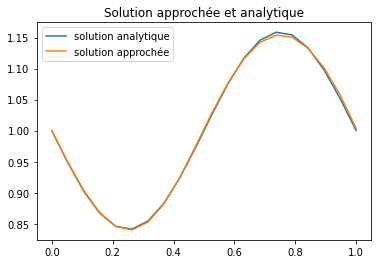

In [23]:
#solution trouvée
Y = [M_0 + (T[i]-t_0)*NN(T[i], w, b, v) for i in range(N)]
#solution analytique
Z = [1 - sin(2*pi*T[i])/2/pi for i in range(N)]

plot(T,Z, label='solution analytique')
plot(T,Y, label='solution approchée')
legend()
title('Solution approchée et analytique')
show()

Affichage des $H$ termes qui composent la sortie du réseau de neurones

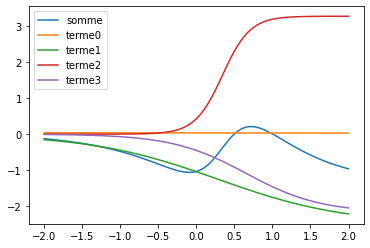

In [20]:
T_test = linspace(-2, 2, 100)

Y = [NN(t, w, b, v) for t in T_test]

plot(T_test,Y, label='somme')

for h in range(H):
    Y_h = sig(T_test*w[h]+b[h])*v[h]
    plot(T_test,Y_h, label='terme'+str(h))
legend()

show()